## Loading data

In [4]:
import os
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone.utils import yolo

In [5]:
name = "tat-dataset_v1"
dataset_dir = "../data/interim/"
classes = ['car', 'head', 'face', 'human', 'carplate']

In [ ]:
# Delete dataset
# dataset = fo.load_dataset(name)
# dataset.delete()

In [ ]:
# The splits to load
splits = ["train"]

# Load the dataset, using tags to mark the samples in each split
dataset = fo.Dataset(name)
for split in splits:
    dataset.add_dir(
        dataset_dir=dataset_dir,
        dataset_type=fo.types.YOLOv5Dataset,
        split=split,
        tags=split,
)

# View summary info about the dataset
print(dataset)

# Print the first few samples in the dataset
print(dataset.head())

In [6]:
# Если датасет уже создан, то его необходимо загрузить
dataset = fo.load_dataset(name)

## Generate Embeddings

Images store a lot of information in their pixel values. Comparing images pixel-by-pixel would be an expensive operation and result in poor quality results. 

Instead, we can use a pretrained computer vision model to generate embeddings for each image. An embedding is a result of processing an image through a model and extracting an intermediate representation of the image from within the model in the form of a vector containing a few thousand values distilling the information stored in the millions of pixels.

For deep learning models, one typically uses the output of a fully-connected layer near the end of the forward pass to generate embeddings.

The [FiftyOne Model Zoo](https://voxel51.com/docs/fiftyone/user_guide/model_zoo/index.html) contains a host of different pretrained models that we can use for this task. In this example, we will use a [MobileNet v2 model trained on ImageNet](https://voxel51.com/docs/fiftyone/user_guide/model_zoo/models.html#mobilenet-v2-imagenet-torch). This model provides relatively high performance, but most importantly is lightweight and can process our dataset quicker than other models. 

Any off-the-shelf model will be informative, but one can easily experiment with other models that may be more useful for particular datasets.

We can easily load the model and compute embeddings on our dataset.

In [14]:
model = foz.load_zoo_model("mobilenet-v2-imagenet-torch")

In [15]:
embeddings = dataset.compute_embeddings(model)

print(embeddings.shape)

 100% |███████████████| 2002/2002 [3.1m elapsed, 0s remaining, 30.9 samples/s]      
(2002, 1280)


## Calculate Similarity

Now that we have significantly reduced the dimensionality of our images, we can use classical similarity algorithms to compute how similar every image embedding is to every other image embedding.

In this case, we will use [cosine similarity provided by Scikit Learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) since this algorithm is simple and works fairly well in high dimensional spaces.

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [17]:
similarity_matrix = cosine_similarity(embeddings)

(2002, 2002)
[[1.         0.73752365 0.6706516  ... 0.71426471 0.65319272 0.75256686]
 [0.73752365 1.         0.86043931 ... 0.7305947  0.65758385 0.65946908]
 [0.6706516  0.86043931 1.         ... 0.69547337 0.58414223 0.6155496 ]
 ...
 [0.71426471 0.7305947  0.69547337 ... 1.         0.70968905 0.71188582]
 [0.65319272 0.65758385 0.58414223 ... 0.70968905 1.         0.78240147]
 [0.75256686 0.65946908 0.6155496  ... 0.71188582 0.78240147 1.        ]]


As you can see, all diagonal values are 1 since every image is identical to itself. We can subtract by the identity matrix (N x N matrix with 1's on the diagonal and 0's elsewhere) in order to zero out the diagonal so those values don't show up when we look for samples with maximum similarity.

In [18]:
n = len(similarity_matrix)

similarity_matrix = similarity_matrix - np.identity(n)

**Note:** Computing cosine similarity on datasets with more than 100,000 images can time and memory intensive. It is recommended to split the embeddings into batches and parallelize the process to speed up this computation.

## Visualize and remove duplicates

We can now iterate through every sample and find which other samples are the most similar to it.






In [19]:
id_map = [s.id for s in dataset.select_fields(["id"])]

for idx, sample in enumerate(dataset):
    sample["max_similarity"] = similarity_matrix[idx].max()
    sample.save()

The [FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/app.html) allows us to visualize and explore our dataset right in this notebook.

In [ ]:
session = fo.launch_app(dataset)

In [20]:
from fiftyone import ViewField as F

dataset.match(F("max_similarity")>0.998)

Dataset:     tat-dataset_v1
Media type:  image
Num samples: 47
Sample fields:
    id:             fiftyone.core.fields.ObjectIdField
    filepath:       fiftyone.core.fields.StringField
    tags:           fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth:   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    max_similarity: fiftyone.core.fields.FloatField
View stages:
    1. Match(filter={'$expr': {'$gt': [...]}})

In [21]:
id_map = [s.id for s in dataset.select_fields(["id"])]

In [22]:
thresh = 0.998
samples_to_remove = set()
samples_to_keep = set()

for idx, sample in enumerate(dataset):
    if sample.id not in samples_to_remove:
        # Keep the first instance of two duplicates
        samples_to_keep.add(sample.id)
        
        dup_idxs = np.where(similarity_matrix[idx] > thresh)[0]
        for dup in dup_idxs:
            # We kept the first instance so remove all other duplicates
            samples_to_remove.add(id_map[dup])

        if len(dup_idxs) > 0:
            sample.tags.append("has_duplicates")
            sample.save()

    else:
        sample.tags.append("duplicate")
        sample.save()

print(len(samples_to_remove) + len(samples_to_keep))

print(len(samples_to_remove))

2002
24


In [24]:
# If you want to remove the samples from the dataset entirely, uncomment the following line

dataset.delete_samples(list(samples_to_remove))


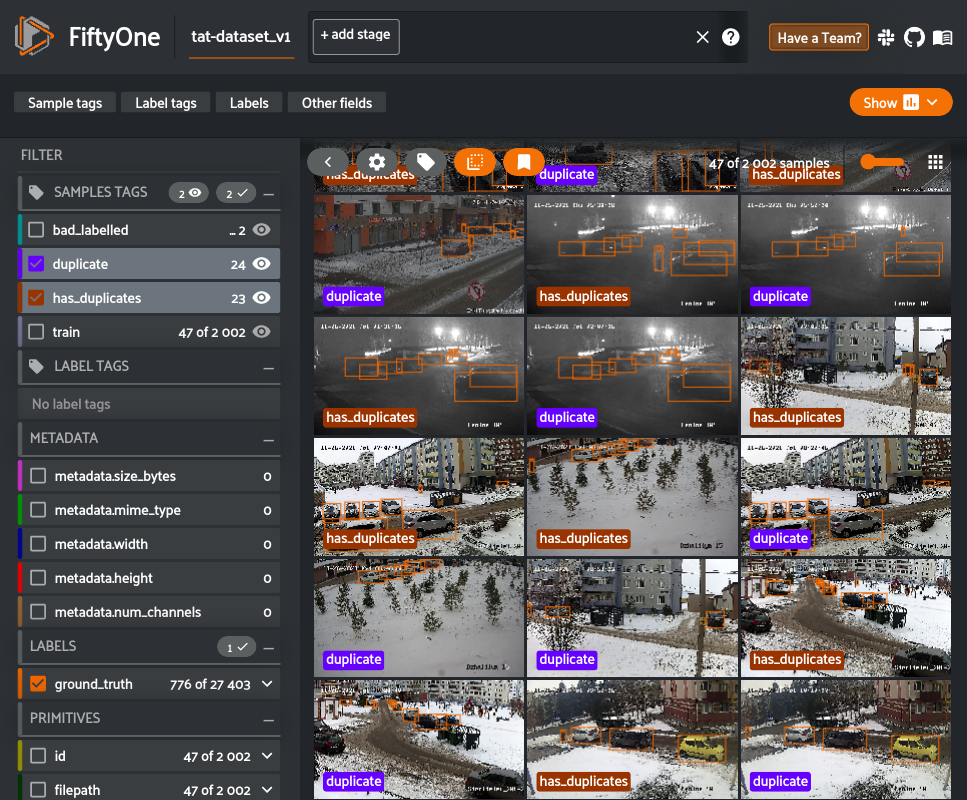

'57bb92bb-6a31-4169-93a7-760739062d22'

In [23]:
session.show()

# Finding duplicate objects

In [ ]:
import fiftyone.utils.iou as foui

foui.compute_max_ious(dataset, "ground_truth", iou_attr="max_iou", classwise=True)
print("Max IoU range: (%f, %f)" % dataset.bounds("ground_truth.detections.max_iou"))

In [ ]:
from fiftyone import ViewField as F
#ground_truth
# Retrieve detections that overlap above a chosen threshold
dups_view = dataset.filter_labels("ground_truth", F("max_iou") > 0.8)
print(dups_view)

In [ ]:
session = fo.launch_app(view=dups_view)

In [ ]:
# Automatically finding duplicates

dup_ids = foui.find_duplicates(
    dataset, "ground_truth", iou_thresh=0.80, classwise=True
)
print("Found %d duplicates" % len(dup_ids))

In [ ]:
# Tag the automatically selected duplicates
dataset.select_labels(ids=dup_ids).tag_labels("duplicate")
print(dataset.count_label_tags())

In [ ]:
session.view = dataset.match_labels(ids=dup_ids)

In [ ]:
dataset.delete_labels(tags="duplicate")

# Удаление изображений на которых отсутствует разметка ключевых объектов

In [ ]:
for_rm = ["0_26-11-2021_06-00-09_AM", "0_25-11-2021_07-51-57_PM", "23-11-2021_02-18-56_PM", "23-11-2021_02-20-28_PM",
         "23-11-2021_02-20-53_PM", "23-11-2021_02-38-18_PM", "23-11-2021_05-36-30_PM", "24-11-2021_02-23-58_PM",
         "24-11-2021_03-18-45_PM", "24-11-2021_04-35-42_AM", "24-11-2021_05-03-48_PM", "24-11-2021_05-47-08_AM",
         "24-11-2021_10-50-09_AM", "24-11-2021_11-09-46_AM", "24-11-2021_12-21-38_PM", "25-11-2021_01-18-30_PM",
         "25-11-2021_05-33-01_AM", "25-11-2021_10-58-05_AM", "26-11-2021_04-47-18_AM", "26-11-2021_07-45-55_AM"]

samples_to_remove = set()

for idx, sample in enumerate(dataset):
    for rmi in for_rm:
        if rmi in sample.filepath:
            sample.tags.append("bad_labelled")
            samples_to_remove.add(sample.id)
            sample.save()

In [ ]:
dataset.delete_samples(list(samples_to_remove))

# Просмотр датасета

In [ ]:
session = fo.launch_app(dataset)

# Экспорт данных

In [ ]:
# Удаление изображений для которых отсутствует файл с разметкой
def del_no_labels(dataset_path):
    for label_file in os.listdir(dataset_path + '/labels/val/'):
        if os.stat(os.path.join(dataset_path, 'labels/val/', label_file)).st_size == 0:
            os.remove(os.path.join(dataset_path, 'labels/val/', label_file))
            os.remove(os.path.join(dataset_path, 'images/val/', label_file.split('.')[0]+'.jpg'))

In [2]:
dataset = fo.load_dataset("tat-dataset_v1")

In [64]:
# All data
EXPORT_DIR = "../data/image-deduplication_new"

dataset.export(dataset_type=fo.types.YOLOv5Dataset, export_dir=EXPORT_DIR, classes=dataset.default_classes,)

del_no_labels(EXPORT_DIR)

 100% |███████████████| 1956/1956 [42.5s elapsed, 0s remaining, 181.0 samples/s]      


In [65]:
# Cars, human
EXPORT_DIR = "../data/image-deduplication_c_h_new"

classes = ['car', 'human']

dataset.export(dataset_type=fo.types.YOLOv5Dataset, export_dir=EXPORT_DIR, classes=classes,)

del_no_labels(EXPORT_DIR)

 100% |███████████████| 1956/1956 [7.9s elapsed, 0s remaining, 158.8 samples/s]      


In [66]:
# Carplate
EXPORT_DIR = "../data/image-deduplication_cp_new"

classes = ['carplate']

dataset.export(dataset_type=fo.types.YOLOv5Dataset, export_dir=EXPORT_DIR, classes=classes,)

del_no_labels(EXPORT_DIR)

 100% |███████████████| 1956/1956 [22.6s elapsed, 0s remaining, 34.9 samples/s]      


In [67]:
# Human, head, face
EXPORT_DIR = "../data/image-deduplication_hhf_new"

classes = ['head', 'face', 'human']

dataset.export(dataset_type=fo.types.YOLOv5Dataset, export_dir=EXPORT_DIR, classes=classes,)

del_no_labels(EXPORT_DIR)

 100% |███████████████| 1956/1956 [7.8s elapsed, 0s remaining, 185.5 samples/s]      


In [ ]:
session.freeze()